In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# VGG16 (w/o data augmentation)

In [2]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
base_dir = r'D:\Anaconda3\Scripts\5 上課資料\電腦視覺與人機互動\20191031HW\cats_and_dogs_small'
print('base_dir :',base_dir,'\n')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
 
print('訓練用的貓照片張數:', len(os.listdir(train_cats_dir)))
print('訓練用的狗照片張數:', len(os.listdir(train_dogs_dir)))
print('驗證用的貓照片張數:', len(os.listdir(validation_cats_dir)))
print('驗證用的狗照片張數:', len(os.listdir(validation_dogs_dir)))
print('測試用的貓照片張數:', len(os.listdir(test_cats_dir)))
print('測試用的狗照片張數:', len(os.listdir(test_dogs_dir)))

base_dir : D:\Anaconda3\Scripts\5 上課資料\電腦視覺與人機互動\20191031HW\cats_and_dogs_small 

訓練用的貓照片張數: 1000
訓練用的狗照片張數: 1000
驗證用的貓照片張數: 500
驗證用的狗照片張數: 500
測試用的貓照片張數: 500
測試用的狗照片張數: 500


In [4]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [5]:
# 使用預先訓練的 convolutional base 萃取特徵
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i, end=' ') # 由於萃取需要較長的時間，我們印出 i 來檢視進度
        if i * batch_size >= sample_count:
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [7]:
# 將資料展平
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
# 建置模型
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6072 - acc: 0.6600 - val_loss: 0.4459 - val_acc: 0.8240
Epoch 2/30
2000/2000 [==============================] - 1s 681us/step - loss: 0.4387 - acc: 0.8040 - val_loss: 0.3707 - val_acc: 0.8460
Epoch 3/30
2000/2000 [==============================] - 1s 678us/step - loss: 0.3662 - acc: 0.8415 - val_loss: 0.3262 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 1s 670us/step - loss: 0.3206 - acc: 0.8700 - val_loss: 0.3053 - val_acc: 0.8740
Epoch 5/30
2000/2000 [==============================] - 1s 688us/step - loss: 0.2807 - acc: 0.8910 - val_loss: 0.2907 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 1s 671us/step - loss: 0.2638 - acc: 0.9000 - val_loss: 0.2707 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 1s 688us/step - loss: 0.2568 - acc: 0.8935 - val_loss: 0.2635 - val_acc: 0.8940
Ep

In [9]:
loss, accuracy = model.evaluate(train_features, train_labels)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

2000/2000 [==============================] - 1s 251us/step

Loss: 0.07, Accuracy: 98.05%


Save image/VGG16_acc
Save image/VGG16_loss


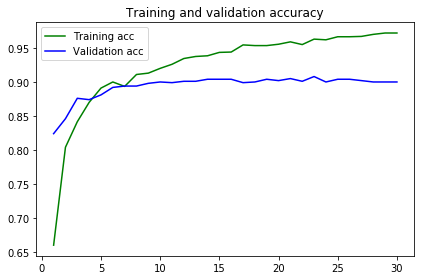

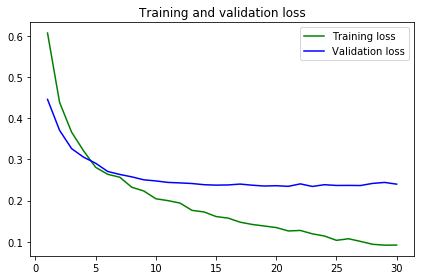

In [10]:
modelname = 'VGG16'

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

metrics = 'acc'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.figure()

metrics = 'loss'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.show()

# VGG16 (with data augmentation)

In [11]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False  

print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [13]:
train_datagen = ImageDataGenerator(
                rescale=1./255, rotation_range=40, width_shift_range=0.2,
                height_shift_range=0.2, shear_range=0.2,
                zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                    target_size=(150, 150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir, target_size=(150, 150), 
                        batch_size=20, class_mode='binary')

model.compile( loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100,
        epochs=30, validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 51s 506ms/step - loss: 0.5921 - acc: 0.6890 - val_loss: 0.4444 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 48s 484ms/step - loss: 0.4771 - acc: 0.7920 - val_loss: 0.3638 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 49s 489ms/step - loss: 0.4316 - acc: 0.8150 - val_loss: 0.3306 - val_acc: 0.8630
Epoch 4/30
100/100 [==============================] - 49s 491ms/step - loss: 0.4002 - acc: 0.8185 - val_loss: 0.3063 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 49s 494ms/step - loss: 0.3805 - acc: 0.8285 - val_loss: 0.2866 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 50s 499ms/step - loss: 0.3736 - acc: 0.8300 - val_loss: 0.2797 - val_acc: 0.8850
Epoch 7/30
100/100 [==============================] - 50s 498ms/step - loss: 0.3591 - acc: 0.8530 - val_lo

In [15]:
model.save('model-VGG16(withDA)-final.h5')
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // batch_size)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))


Loss: 0.00, Accuracy: 90.20%


Save image/VGG16(withDA)_acc
Save image/VGG16(withDA)_loss


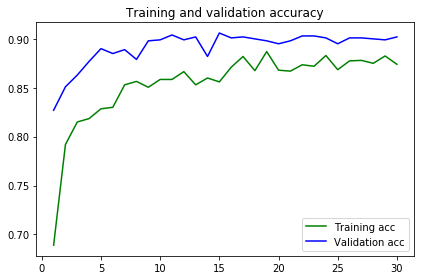

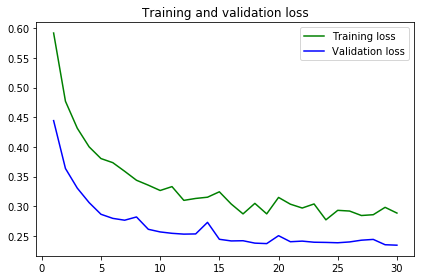

In [16]:
modelname = 'VGG16(withDA)'

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

metrics = 'acc'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.figure()

metrics = 'loss'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.show()

# ResNet50

In [17]:
import sys
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image

In [18]:
# 資料路徑
DATASET_PATH  = 'D:/Anaconda3/Scripts/5 上課資料/電腦視覺與人機互動/20191031HW/cats_and_dogs_small'
# 影像大小
IMAGE_SIZE = (224, 224)
# 影像類別數
NUM_CLASSES = 2
# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 2
# 凍結網路層數
FREEZE_LAYERS = 2
# Epoch 數
NUM_EPOCHS = 20
# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

In [19]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/validation',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

Class #0 = cats
Class #1 = dogs
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
_____________________________________________________________________________

In [21]:
# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Epoch 1/20
1000/1000 [==============================] - 497s 497ms/step - loss: 0.4977 - acc: 0.7445 - val_loss: 0.0939 - val_acc: 0.9680
Epoch 2/20
1000/1000 [==============================] - 457s 457ms/step - loss: 0.2596 - acc: 0.8880 - val_loss: 0.0672 - val_acc: 0.9720
Epoch 3/20
1000/1000 [==============================] - 458s 458ms/step - loss: 0.1368 - acc: 0.9480 - val_loss: 0.0772 - val_acc: 0.9770
Epoch 4/20
1000/1000 [==============================] - 458s 458ms/step - loss: 0.1000 - acc: 0.9610 - val_loss: 0.0702 - val_acc: 0.9780
Epoch 5/20
1000/1000 [==============================] - 458s 458ms/step - loss: 0.0899 - acc: 0.9635 - val_loss: 0.0868 - val_acc: 0.9790
Epoch 6/20
1000/1000 [==============================] - 458s 458ms/step - loss: 0.0764 - acc: 0.9705 - val_loss: 0.1026 - val_acc: 0.9760
Epoch 7/20
1000/1000 [==============================] - 459s 459ms/step - loss: 0.0666 - acc: 0.9765 - val_loss: 0.0604 - val_acc: 0.9850
Epoch 8/20
1000/1000 [============

In [22]:
scores = model.evaluate_generator(generator=validation_generator, steps=validation_generator.samples // BATCH_SIZE)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (scores[0]/100, scores[1]*100))


Loss: 0.00, Accuracy: 90.20%


Save image/ResNet50_acc
Save image/ResNet50_loss


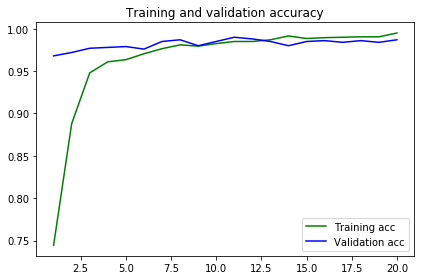

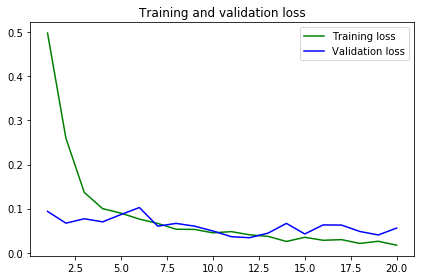

In [23]:
modelname = 'ResNet50'

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

metrics = 'acc'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.figure()

metrics = 'loss'
filename = 'image/'+ modelname + '_' + metrics
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(filename, dpi=300)
print('Save',filename)
plt.show()